In [1]:
def hyperbolic(t, qi, di, b):
  """
  Hyperbolic decline function
  """
  import numpy as np
  return qi / (np.abs((1 + b * di * t))**(1/b))

def arps_fit(t, q, plot=None):
  """
  Arps Decline Curve Analysis using Non-Linear Curve-Fitting
  
  Input:
  t = time array (in numpy datetime64)
  q = production rate array (unit: STB/day, or SCF/day)
  Output:
  qi = initial production rate (unit: STB/day, or SCF/day)
  di = initial decline rate (unit: STB/day, or SCF/day)
  b = decline exponent 
  """
  import numpy as np
  import datetime
  from scipy.optimize import curve_fit
  import matplotlib.pyplot as plt

  def hyperbolic(t, qi, di, b):
    return qi / (np.abs((1 + b * di * t))**(1/b))
  
  def rmse(y, yfit):
    N = len(y)
    return np.sqrt(np.sum(y-yfit)**2 / N)

  # subtract one datetime to another datetime
  date = t
  timedelta = [j-i for i, j in zip(t[:-1], t[1:])]
  timedelta = np.array(timedelta)
  timedelta = timedelta / datetime.timedelta(days=1)

  # take cumulative sum over timedeltas
  t = np.cumsum(timedelta)
  t = np.append(0, t)
  t = t.astype(float)

  # normalize the time and rate data
  t_normalized = t / max(t)
  q_normalized = q / max(q)  

  # fitting the data with the hyperbolic function
  popt, pcov = curve_fit(hyperbolic, t_normalized, q_normalized)
  qi, di, b = popt

  # RMSE is calculated on the normalized variables
  qfit_normalized = hyperbolic(t_normalized, qi, di, b)
  RMSE = rmse(q_normalized, qfit_normalized)

  # De-normalize qi and di
  qi = qi * max(q)
  di = di / max(t)

  if plot==True:
    # Print all parameters and RMSE
    print('Initial production rate (qi)  : {:.5f} VOL/D'.format(qi))
    print('Initial decline rate (di)     : {:.5f} VOL/D'.format(di))
    print('Decline coefficient (b)       : {:.5f}'.format(b))
    print('RMSE of regression            : {:.5f}'.format(RMSE))  

    # Produce the hyperbolic curve (fitted)
    tfit = np.linspace(min(t), max(t), 100)
    qfit = hyperbolic(tfit, qi, di, b)

    # Plot data and hyperbolic curve
    plt.figure(figsize=(10,7))

    plt.step(t, q, color='blue', label="Data")
    plt.plot(tfit, qfit, color='red', label="Hyperbolic Curve")
    plt.title('Decline Curve Analysis', size=20, pad=15)
    plt.xlabel('Days')
    plt.ylabel('Rate (SCF/d)')
    plt.xlim(min(t), max(t)); plt.ylim(ymin=0)

    plt.legend()
    plt.grid()
    plt.show()

  return qi, di, b, RMSE

def arps_bootstrap(t, q, size=1):
    """
    Bootstrapping of Decline Curves
    """
    import numpy as np
    import datetime
    from scipy.optimize import curve_fit
    import matplotlib.pyplot as plt

    """ The exact copy of "arps_fit" function """
#     def hyperbolic(t, qi, di, b):
#       return qi / (np.abs((1 + b * di * t))**(1/b))
    
    def rmse(y, yfit):
      N = len(y)
      return np.sqrt(np.sum(y-yfit)**2 / N)

    # subtract one datetime to another datetime
    date = t
    timedelta = [j-i for i, j in zip(t[:-1], t[1:])]
    timedelta = np.array(timedelta)
    timedelta = timedelta / datetime.timedelta(days=1)

    # take cumulative sum over timedeltas
    t = np.cumsum(timedelta)
    t = np.append(0, t)
    t = t.astype(float)

    # normalize the time and rate data
    t_normalized = t / max(t)
    q_normalized = q / max(q)      

    # Set up array of indices to sample from: inds
    inds = np.arange(0, len(t_normalized))

    # Initialize replicates for qi, di, b
    bs_qi_reps = np.empty(size)
    bs_di_reps = np.empty(size)
    bs_b_reps = np.empty(size)   

    plt.figure(figsize=(10,7)) 

    # Generate replicates
    for i in range(size):
        bs_inds = np.random.choice(inds, size=len(inds))
        bs_x, bs_y = t_normalized[bs_inds], q_normalized[bs_inds]
        popt, pcov = curve_fit(hyperbolic, bs_x, bs_y)

        # qi, di, and b replicates
        bs_qi_reps[i], bs_di_reps[i], bs_b_reps[i] = popt

        # Denormalize replicates
        bs_qi_reps[i] = bs_qi_reps[i] * max(q)
        bs_di_reps[i] = bs_di_reps[i] / max(t)
    
        # Produce the hyperbolic curve (fitted)
        tfit = np.linspace(min(t), max(t), 100)
        qfit_reps = hyperbolic(tfit, bs_qi_reps[i], bs_di_reps[i], bs_b_reps[i])

        # Plot hyperbolic curve replicates
        plt.plot(tfit, qfit_reps, color='orange', alpha=0.3)

    # Calculate 95% CI
    ci95_qi = np.percentile(bs_qi_reps, [2.5, 97.5])
    ci95_di = np.percentile(bs_di_reps, [2.5, 97.5])
    ci95_b = np.percentile(bs_b_reps, [2.5, 97.5])

    min_qi, max_qi = ci95_qi
    min_di, max_di = ci95_di
    min_b, max_b = ci95_b

    print("95% CI of initial production rate (qi) : {:.5f} to {:.5f} VOL/D".format(min_qi, max_qi))
    print("95% CI of initial decline rate (di)    : {:.5f} to {:.5f} VOL/D".format(min_di, max_di))
    print("95% CI of decline exponent (b)         : {:.5f} to {:.5f}".format(min_b, max_b))

    ## Production rate using min CI
    # qfit_min_ci = hyperbolic(tfit, min_qi, min_di, min_b) 
    # qfit_max_ci = hyperbolic(tfit, max_qi, max_di, max_b) 

    # The exact DCA
    qi, di, b, RMSE = arps_fit(date, q)
    qfit = hyperbolic(tfit, qi, di, b)    

    plt.plot(tfit, qfit_reps, color='orange', alpha=0.3, label="Replicates")
    # plt.plot(tfit, qfit_min_ci, "--", color='purple', label="Minimum 95% CI")
    # plt.plot(tfit, qfit_max_ci, "--", color='purple', label="Minimum 95% CI")
    plt.plot(tfit, qfit, color="red", label="Hyperbolic Curve")
    plt.step(t, q, color='blue', label="Data")
    plt.title('Decline Curve Analysis', size=20, pad=15)
    plt.xlabel('Days')
    plt.ylabel('Rate (SCF/d)')
    plt.xlim(min(t), max(t))
    plt.ylim(0, max(q))

    plt.legend()
    plt.grid()
    plt.show()

    return ci95_qi, ci95_di, ci95_b

def remove_outlier(df, column_name, window, number_of_stdevs_away_from_mean, trim=False):
  """
  Removing outlier of production data and trim initial buildup
  INPUT:
  df: Production dataframe
  column_name: Column name of production rate
  window: Rolling average window
  number_of_stdevs_away_from_mean: Distance from standard dev. where outliers
                                   will be removed
  trim: Option to trim initial buildup (Because buildup is an outlier). 
        Default is False.
  OUTPUT:
  df: New dataframe where outliers have been removed 
  """
  import pandas as pd

  df[column_name+'_rol_Av']=df[column_name].rolling(window=window, center=True).mean()
  df[column_name+'_rol_Std']=df[column_name].rolling(window=window, center=True).std()

  # Detect anomalies by determining how far away from the mean (in terms of standard deviation)
  df[column_name+'_is_Outlier']=(abs(df[column_name]-df[
                              column_name+'_rol_Av'])>(
                              number_of_stdevs_away_from_mean*df[
                              column_name+'_rol_Std']))
  
  # outlier and not-outlier will be recorded in the '_is_Outlier'
  # column as 'True' and 'False'. Now, outlier is removed, so column that
  # contains 'True' values are masked out
  result = df.drop(df[df[column_name+'_is_Outlier'] == True].index).reset_index(drop=True)

  # Remove rows where "_rol_Av" has NaNs
  result = result[result[column_name+'_rol_Av'].notna()]  

  if trim==True:
    # Trim initial buildup
    maxi = result[column_name+'_rol_Av'].max()
    maxi_index = (result[result[column_name+'_rol_Av']==maxi].index.values)[0]
    result = result.iloc[maxi_index:,:].reset_index(drop=True)

  return result  

def convert_date_to_days(t):
  """
  Convert Numpy Datetime to Days 
  """
  import datetime
  import numpy as np
  
  # subtract one datetime to another datetime
  timedelta = [j-i for i, j in zip(t[:-1], t[1:])]
  timedelta = np.array(timedelta)
  timedelta = timedelta / datetime.timedelta(days=1)

  # take cumulative sum over timedeltas
  t = np.cumsum(timedelta)
  t = np.append(0, t)
  t = t.astype(float)
  return t

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
df = pd.read_csv('norne_production_rate_sample.csv')

# convert date string to Panda datetime format
df['Date'] =  pd.to_datetime(df['Date'], format='%Y-%m-%d') 

t = df['Date']
q = df['Rate (SCF/d)']

print(df.head(10))

        Date  Rate (SCF/d)
0 2004-04-01    2706039.00
1 2004-05-01    2492086.20
2 2004-06-02    1816846.10
3 2004-07-02    1920207.40
4 2004-07-04    1683521.40
5 2004-07-25    1847040.90
6 2004-08-01    1536201.60
7 2004-08-16    1711845.00
8 2004-08-17     677522.19
9 2004-09-04     762001.13


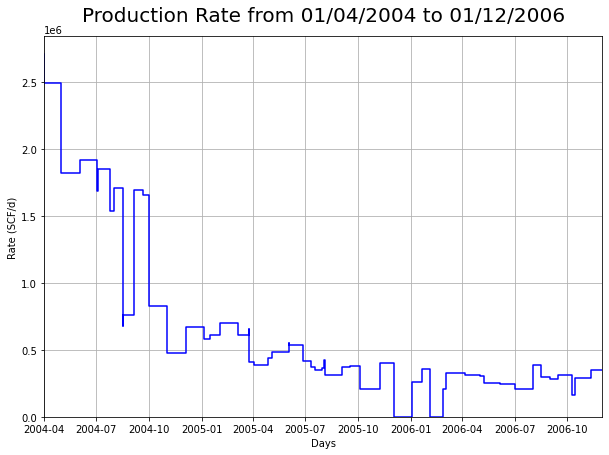

In [4]:
plt.figure(figsize=(10,7))

plt.step(t, q, color='blue')
plt.title('Production Rate from 01/04/2004 to 01/12/2006', size=20, pad=15)
plt.xlabel('Days')
plt.ylabel('Rate (SCF/d)')
plt.xlim(min(t), max(t)); plt.ylim(ymin=0)

plt.grid()
plt.show()

Initial production rate (qi)  : 2866266.45256 VOL/D
Initial decline rate (di)     : 0.00669 VOL/D
Decline coefficient (b)       : 0.50003
RMSE of regression            : 0.02259


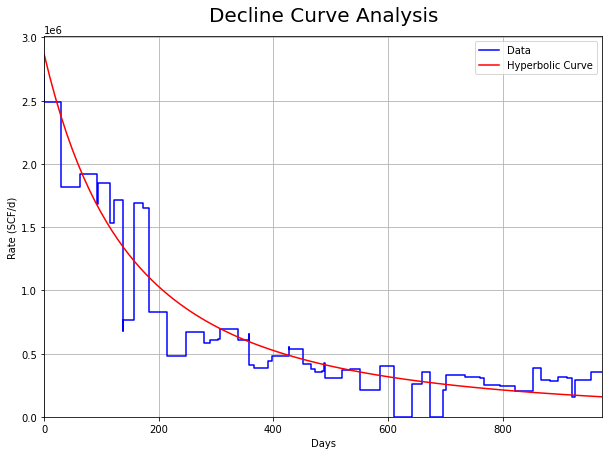

In [5]:
# Decline curve analysis
qi, di, b, RMSE = arps_fit(t, q, plot=True)

95% CI of initial production rate (qi) : 2457251.51881 to 4937220445.68548 VOL/D
95% CI of initial decline rate (di)    : 0.00319 to 45.37362 VOL/D
95% CI of decline exponent (b)         : -0.34890 to 1.05246


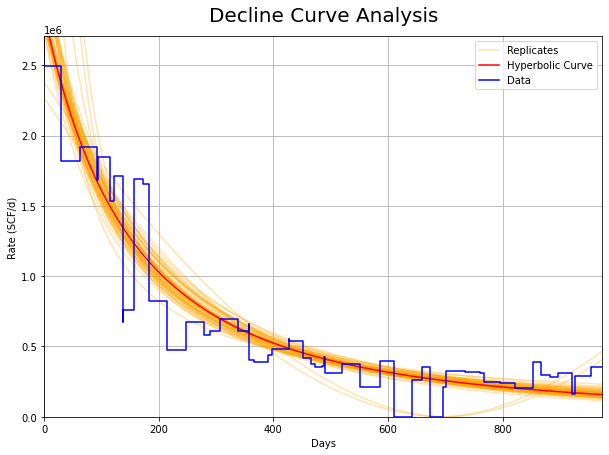

In [8]:
# Decline curve analysis with bootstrapping
ci95_qi, ci95_di, ci95_b = arps_bootstrap(t, q, size=50)